In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as mse
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      ProbabilityOfImprovement
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
def myplot(y_true_list, y_pred_list,var_list, title_str_list, color_list,region):
    fig, axes = plt.subplots(1, 2, figsize=(5.5*2, 4.5))
    fs = 18
    
    for i in range(len(axes)):
        axes[i].scatter(y_true_list[i], y_pred_list[i], alpha = 0.6, c = color_list[i])
        axes[i].plot(region,region, 'k--', alpha=0.75, zorder=0)
        axes[i].errorbar(y_true_list[i],y_pred_list[i], yerr = var_list[i], ms = 0, 
                 ls = '', capsize = 2, alpha = 0.6,
                 color = 'gray', zorder = 0)
        axes[i].set_xlabel('Ground Truth', fontsize = fs)
        axes[i].set_ylabel('Prediction', fontsize = fs)
        axes[i].set_xlim(region)
        axes[i].set_ylim(region)
        rmse = mse(y_true_list[i],y_pred_list[i],squared=False)
        title = title_str_list[i] + " (RMSE = %.3f)"%rmse
        axes[i].set_title(title, fontsize = fs)
        axes[i].grid(True, linestyle='-.')

In [3]:
# 参数空间
Tip_Height_min, Tip_Height_max, Tip_Height_step = [0.5, 50, 0.5]
Tip_Height_var = np.arange(Tip_Height_min, Tip_Height_max+0.1*Tip_Height_step,Tip_Height_step)
Tip_Height_num = len(Tip_Height_var)

Dispense_Speed_AS_min, Dispense_Speed_AS_max, Dispense_Speed_AS_step = [20,500,10]
Dispense_Speed_AS_var = np.arange(Dispense_Speed_AS_min, Dispense_Speed_AS_max+0.1*Dispense_Speed_AS_step,Dispense_Speed_AS_step)
Dispense_Speed_AS_num = len(Dispense_Speed_AS_var)

Spin_Speed_AS_min, Spin_Speed_AS_max, Spin_Speed_AS_step = [500,7000,100]
Spin_Speed_var = np.arange(Spin_Speed_AS_min,Spin_Speed_AS_max+0.1*Spin_Speed_AS_step,Spin_Speed_AS_step)
Spin_Speed_num = len(Spin_Speed_var)

Volume_AS_min, Volume_AS_max, Volume_AS_step = [50,300,10]
Volume_AS_var = np.arange(Volume_AS_min, Volume_AS_max+0.1*Volume_AS_step, Volume_AS_step)
Volume_AS_num = len(Volume_AS_var)

Timing_AS_min, Timing_AS_max, Timing_AS_step = [2,25,1]
Timing_AS_var = np.arange(Timing_AS_min, Timing_AS_max+0.1*Timing_AS_step,Timing_AS_step)
Timing_AS_num = len(Timing_AS_var)

x_label=[
    'Tip_Height',
    'Dispense_Speed_AS',
    'Spin_Speed_AS',
    'Volume_AS',
    'Timing_AS'
]

var_array = [
    Tip_Height_var,
    Dispense_Speed_AS_var,
    Spin_Speed_var,
    Volume_AS_var,
    Timing_AS_var
]


def x_normalizer(X, var_array = var_array):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                         max(var_array[i]), 
                         min(var_array[i])) for i in range(len(x))])
            
    return np.array(x_norm)

def x_denormalizer(x_norm, var_array = var_array):
    
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                              max(var_array[i]), 
                              min(var_array[i])) for i in range(len(x))])

    return np.array(x_original)


def get_closest_array(suggested_x):
    
    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value
    
    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [4]:
data  = pd.read_excel('../高斯过程.xlsx',usecols=[i for i in range(1,9)],sheet_name='round1').dropna()
Data = data.values

X = Data[:,:5]
Y = Data[:,5]

X_norm = x_normalizer(X)
ss_y =600000
Y_norm = Y/ss_y 

Train_X, Test_X, Train_y, Test_y = train_test_split(X_norm, Y_norm, test_size = 0.3,random_state=1)


In [5]:
data

,Tip Height \n(mm) 0.5-50,Dispense Speed \n(ul/s) 20-500,AS Spin Speed \n(rpm) 500-7000,AS Volume \n(ul) 50-300,Timing AS\n (s) 2-18,PL Intensity ave,PL Intensity CV,Peak CV
0,1.5,90.0,5600.0,50.0,12.0,175357.061097,0.173763,0.001152
1,20.0,460.0,2300.0,220.0,25.0,178837.692437,0.309365,0.001924
2,4.0,250.0,7000.0,300.0,22.0,324724.062188,0.119376,0.000455
3,8.0,260.0,4900.0,100.0,5.0,251923.044783,0.227518,0.000707
4,15.5,170.0,5100.0,70.0,7.0,228986.076923,0.144984,0.000439
5,29.5,380.0,5800.0,100.0,13.0,241866.564743,0.123097,0.001060
6,32.0,450.0,800.0,140.0,15.0,188744.000000,0.099226,0.000456
7,50.0,200.0,1700.0,110.0,6.0,245398.692308,0.099245,0.000540
9,30.0,170.0,500.0,250.0,2.0,334861.307692,0.033553,0.000208
10,27.5,440.0,7000.0,290.0,2.0,367440.769231,0.060029,0.000383


In [6]:
Train_y

array([0.61083043, 0.38164346, 0.29806282, 0.60124186, 0.29226177,
       0.45422564, 0.61240128, 0.55810218, 0.62104885, 0.67380538,
       0.40311094])

In [7]:
rbf = GPy.kern.RBF(input_dim=5, variance=1., lengthscale=1.,ARD=True)
linear = GPy.kern.Linear(input_dim=5,ARD =True)
m52 = GPy.kern.Matern52(input_dim = 5, ARD =True)
m52.lengthscale.constrain_bounded(1e-2, 1)
m52.variance.constrain_bounded(1e-1, 1000.0)

kernel = m52
model = GPy.models.GPRegression(Train_X,-Train_y.reshape(-1,1),kernel)

model.randomize()
model.optimize_restarts(num_restarts = 50)
model.optimize(messages=True)

y_pred_train = model.predict(Train_X)[0].ravel()
y_pred_test = model.predict(Test_X)[0].ravel()
var_train = np.sqrt(model.predict(Train_X)[1]).ravel()
var_test = np.sqrt(model.predict(Test_X)[1]).ravel()

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


Optimization restart 1/50, f = -1.3910452225769596
Optimization restart 2/50, f = -1.230662075077813
Optimization restart 3/50, f = -1.3910442550963573
Optimization restart 4/50, f = -1.3910499618292844
Optimization restart 5/50, f = -1.391039181609246
Optimization restart 6/50, f = -1.3910400190520287
Optimization restart 7/50, f = -1.3910476429555665
Optimization restart 8/50, f = -1.3910427348440075
Optimization restart 9/50, f = -1.3910497675538371
Optimization restart 10/50, f = -1.3910223203316372
Optimization restart 11/50, f = -1.3910347903928795
Optimization restart 12/50, f = -1.3910500680812632
Optimization restart 13/50, f = -1.3910499116511037
Optimization restart 14/50, f = -1.391042280917885
Optimization restart 15/50, f = -1.3910473319858712
Optimization restart 16/50, f = -1.3910481713118399
Optimization restart 17/50, f = -1.2306697927549184
Optimization restart 18/50, f = -1.3910300734942602
Optimization restart 19/50, f = -1.391046693053906
Optimization restart 20/5

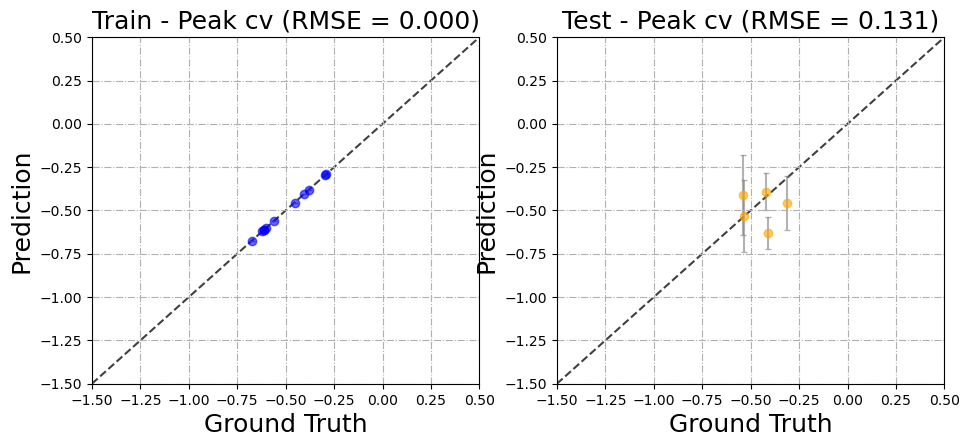

In [8]:
myplot([-Train_y,-Test_y],[y_pred_train,y_pred_test],[var_train,var_test],
       ["Train - Peak cv","Test - Peak cv"],
       ["blue","orange"],
      [-1.5,0.5])
#plt.savefig('result',dpi=1000)

In [9]:
X_normalize = x_normalizer(Data[:,:5])
Y_normalize = Data[:,5]/ss_y
m52 = GPy.kern.Matern52(input_dim = 5, ARD =True)
m52.lengthscale.constrain_bounded(1e-2, 1)
m52.variance.constrain_bounded(1e-1, 1000.0)

kernel = m52
model = GPy.models.GPRegression(X_normalize,-Y_normalize.reshape(-1,1),kernel)

model.randomize()
model.optimize_restarts(num_restarts = 50)
model.optimize(messages=True)

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


Optimization restart 1/50, f = -3.8897902018301913
Optimization restart 2/50, f = -3.8897920061382383
Optimization restart 3/50, f = -3.8897924268096453
Optimization restart 4/50, f = -3.889785728615122
Optimization restart 5/50, f = -3.8897733089050446
Optimization restart 6/50, f = -3.889790086666869
Optimization restart 7/50, f = -3.8897921350853943
Optimization restart 8/50, f = -3.8897761494318868
Optimization restart 9/50, f = -3.8897918640707294
Optimization restart 10/50, f = -3.8897905685153074
Optimization restart 11/50, f = -3.277759346793644
Optimization restart 12/50, f = -3.2777556902481972
Optimization restart 13/50, f = -3.889792174343267
Optimization restart 14/50, f = -3.8897888440826716
Optimization restart 15/50, f = -3.889791284322028
Optimization restart 16/50, f = -3.2378427032024977
Optimization restart 17/50, f = -3.8897717134732277
Optimization restart 18/50, f = -3.889791439036202
Optimization restart 19/50, f = -3.8897915823637366
Optimization restart 20/50,

0.9964716527368328


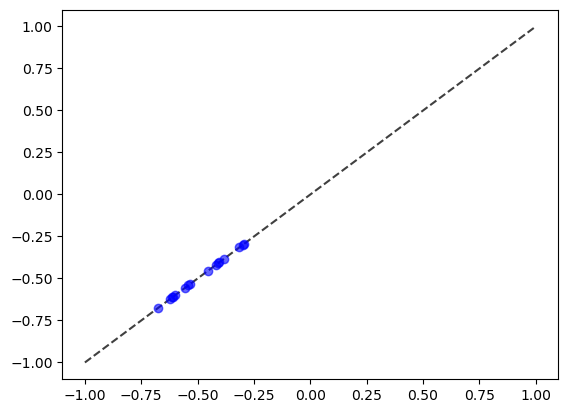

In [10]:
y_pred = model.predict(X_normalize)[0]
plt.scatter(-Y_normalize,y_pred,c='b',alpha=0.6)
plt.plot([-1,1],[-1,1], 'k--', alpha=0.75, zorder=0)
print(mse(Y_normalize,y_pred,squared=False))

In [11]:
parameter_space = ParameterSpace([ContinuousParameter('Tip_Height', 0-1/(Tip_Height_num-1)/2, 1+1/(Tip_Height_num-1)/2),
                                  ContinuousParameter('Dispense_Speed_AS', 0-1/(Dispense_Speed_AS_num-1)/2, 1+1/(Dispense_Speed_AS_num-1)/2),
                                  ContinuousParameter('Spin_Speed', 0-1/(Spin_Speed_num-1)/2, 1+1/(Spin_Speed_num-1)/2),
                                  ContinuousParameter('Volume_AS', 0-1/(Volume_AS_num-1)/2, 1+1/(Volume_AS_num-1)/2),
                                  ContinuousParameter('Timing_AS', 0-1/(Timing_AS_num-1)/2, 1+1/(Timing_AS_num-1)/2)
                                  
                                  ])
parameter_space.parameters

[ContinuousParameter(Tip_Height, -0.005050505050505051, 1.005050505050505),
 ContinuousParameter(Dispense_Speed_AS, -0.010416666666666666, 1.0104166666666667),
 ContinuousParameter(Spin_Speed, -0.007692307692307693, 1.0076923076923077),
 ContinuousParameter(Volume_AS, -0.02, 1.02),
 ContinuousParameter(Timing_AS, -0.021739130434782608, 1.0217391304347827)]

In [14]:
np.random.seed(1000)

objective_model = GPyModelWrapper(model)
bs = 50


acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)#NegativeLowerConfidenceBound(objective_model, beta = beta[i])#ExpectedImprovement(objective_model, jitter=.1)#NegativeLowerConfidenceBound(objective_model, beta = 1)

bayesopt= BayesianOptimizationLoop(model=objective_model, 
                                   space=parameter_space, 
                                   acquisition=acquisition,
                                   batch_size = bs)


X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)
x = get_closest_array(x_denormalizer(X_new,var_array))
df_Xnew = pd.DataFrame(x, columns = x_label)
u = -ss_y*model.predict(x_normalizer(x))[0]
sigma = ss_y*model.predict(x_normalizer(x))[1]
pred = pd.DataFrame(np.append(u,sigma,axis=1),columns=['pred_mean','pred_sigma'])
final = pd.concat([df_Xnew, pred], axis=1)
final


1000000
LPP
Init point :  [ 4.54194707e-01  2.12947520e-02 -3.54214872e-04  1.00510389e+00
  6.49574732e-01]
opt point :  (array([[ 0.45881371, -0.01041667, -0.0053509 ,  1.02      ,  0.65565693]]), array([[-0.8459169]]))
acq_max =  [[0.8459169]]
Init point :  [0.38879917 0.00333483 0.05567082 1.004719   0.67705811]
opt point :  (array([[ 0.45883583, -0.01041667, -0.00538894,  1.02      ,  0.65564874]]), array([[-0.8459169]]))
acq_max =  [[0.8459169]]
Init point :  [0.37018992 0.01000804 0.00654183 1.00978711 0.64785074]
opt point :  (array([[ 0.45882474, -0.01041667, -0.00536322,  1.02      ,  0.6556649 ]]), array([[-0.8459169]]))
acq_max =  [[0.8459169]]
Init point :  [0.52538245 0.00316788 0.07064632 1.01966272 0.66407982]
opt point :  (array([[ 0.45881952, -0.01041667, -0.00535401,  1.02      ,  0.65565341]]), array([[-0.8459169]]))
acq_max =  [[0.8459169]]
Init point :  [0.48574313 0.02302055 0.00404617 1.01696376 0.71126853]
opt point :  (array([[ 0.45881494, -0.01041667, -0.0053

Init point :  [0.41504164 0.03041535 0.01922387 1.01798163 0.65586135]
opt point :  (array([[ 0.45882881, -0.01041667, -0.00536696,  1.02      ,  0.65566685]]), array([[-0.8459169]]))
acq_max =  [[0.8459169]]
Init point :  [0.4059089  0.01918171 0.0410836  1.01409761 0.69610631]
opt point :  (array([[ 0.45881458, -0.01041667, -0.00535032,  1.02      ,  0.65565453]]), array([[-0.8459169]]))
acq_max =  [[0.8459169]]
Init point :  [ 0.39363434  0.00372196 -0.00757961  1.00361747  0.64344234]
opt point :  (array([[ 0.45881809, -0.01041667, -0.00534799,  1.02      ,  0.65565601]]), array([[-0.8459169]]))
acq_max =  [[0.8459169]]
Init point :  [0.41409266 0.02649102 0.07282159 1.00807948 0.5789771 ]
opt point :  (array([[ 0.45881511, -0.01041667, -0.00534852,  1.02      ,  0.6556543 ]]), array([[-0.8459169]]))
acq_max =  [[0.8459169]]
Init point :  [0.48133197 0.05791181 0.04689081 1.01856313 0.6333135 ]
opt point :  (array([[ 0.45882382, -0.01041667, -0.00536199,  1.02      ,  0.65566137]])

,Tip_Height,Dispense_Speed_AS,Spin_Speed_AS,Volume_AS,Timing_AS,pred_mean,pred_sigma
0,23.0,20.0,500.0,300.0,17.0,424194.600779,12998.914662
1,23.0,20.0,500.0,300.0,17.0,424194.600779,12998.914662
2,23.0,20.0,500.0,300.0,17.0,424194.600779,12998.914662
3,23.0,20.0,500.0,300.0,17.0,424194.600779,12998.914662
4,23.0,20.0,500.0,300.0,17.0,424194.600779,12998.914662
5,23.0,20.0,500.0,300.0,17.0,424194.600779,12998.914662
6,23.0,20.0,500.0,300.0,17.0,424194.600779,12998.914662
7,23.0,20.0,500.0,300.0,17.0,424194.600779,12998.914662
8,23.0,20.0,500.0,300.0,17.0,424194.600779,12998.914662
9,23.0,20.0,500.0,300.0,17.0,424194.600779,12998.914662


In [14]:
final.to_excel('Intensity ave2_gp.xlsx')

In [16]:
np.random.seed(1000)

objective_model = GPyModelWrapper(model)
bs = 1

beta = [0.1,1,10]
recommend_point = []
num = 3
for i in range(num):

    acquisition = NegativeLowerConfidenceBound(objective_model, beta = beta[i])#NegativeLowerConfidenceBound(objective_model, beta = beta[i])#ExpectedImprovement(objective_model, jitter=.1)#NegativeLowerConfidenceBound(objective_model, beta = 1)

    bayesopt= BayesianOptimizationLoop(model=objective_model, 
                                       space=parameter_space, 
                                       acquisition=acquisition,
                                       batch_size = bs)


    X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)

    recommend_point.append(get_closest_array(x_denormalizer(X_new,var_array)))
    
recommend_point_pd = pd.DataFrame(np.array(recommend_point).reshape(-1,5), columns = x_label)

rp = x_normalizer(np.array(recommend_point).reshape(num,5))
u = -ss_y*model.predict(rp)[0] #均值
sigma = ss_y*model.predict(rp)[1] #方差
pred = pd.DataFrame(np.append(u,sigma,axis=1),columns=['pred_mean','pred_sigma'])
final = pd.concat([recommend_point_pd, pred], axis=1)
final

1000000
Init point :  [0.47841227 0.07980027 0.04168237 1.01893663 0.62993468]
opt point :  (array([[0.47748549, 0.11674522, 0.04610119, 1.02      , 0.62340316]]), array([[-0.73278483]]))
acq_max =  [[0.73278483]]
1000000
Init point :  [0.38879917 0.00333483 0.05567082 1.004719   0.67705811]
opt point :  (array([[ 0.4588295 , -0.01041667, -0.00537635,  1.02      ,  0.65564598]]), array([[-0.85720078]]))
acq_max =  [[0.85720078]]
1000000
Init point :  [-0.00492788 -0.00956263  0.95669542  0.9814621   0.02473375]
opt point :  (array([[-0.00505051, -0.01041667,  1.00769231,  1.02      , -0.02173913]]), array([[-2.78803365]]))
acq_max =  [[2.78803365]]


,Tip_Height,Dispense_Speed_AS,Spin_Speed_AS,Volume_AS,Timing_AS,pred_mean,pred_sigma
0,24.0,80.0,800.0,300.0,16.0,430124.577809,9726.618339
1,23.0,20.0,500.0,300.0,17.0,424194.600779,12998.914662
2,0.5,20.0,7000.0,300.0,2.0,278885.387882,31387.746863
